# Part A: Centrality measures

### Procedure
1. Plot the underground network (stations and connections)
2. Calculate the two necessary centrality measures.
3. Plot the network again, but now change the colour of the stations based on centrality
(one plot per measure).
4. Perform the following attacks on the network
a) Close N random stations;
b) Close N specific stations based on some criteria, e.g., spatial location or
number of passengers
5. After each attack, repeat points 2 and 3.

# Data prepartion and cleaning 

In [1]:
# importing the relevant libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# reading in the London underground station and conenctions data as pandas dataframes
u_stations = pd.read_csv('data/london_tube_stations.csv')
u_connections = pd.read_csv('data/london_tube_connections.csv')

In [3]:
# loading and exploring the data
u_stations
u_connections

,station1,station2,line,time
0,11,163,1,1
1,11,212,1,2
2,49,87,1,1
3,49,197,1,2
4,82,163,1,2
...,...,...,...,...
401,198,272,11,1
402,198,273,11,3
403,224,260,11,3
404,245,272,11,3


In [4]:
u_stations.shape
# there are 302 rows and 8 columns in the 'u_conenctions' dataframe
u_connections.shape
# there are 406 rows and 4 columns in the 'u_conenctions' dataframe

# checking for null values in both dataframes
u_stations.isnull().sum()
#u_connections.isnull().sum()

id                0
latitude          0
longitude         0
name              0
display_name    106
zone              0
total_lines       0
rail              0
dtype: int64

### The following analysis will rely on a weight being assigned to each edge of the network. In this instance TfL passenger counts will be the weight. For example, the edge connecting station A to station B, will use the total entry counts at station A.
Let's create a dataframe that holds all the relevant inforamtion we need  

In [5]:
# reading in the weekday sample TfL data as a pandas dataframe
entry_counts = pd.read_csv('data/counts-entries-10-weekday-sample.csv')
entry_counts

,nlc,Station,Date,Note,0200-0215,0215-0230,0230-0245,0245-0300,0300-0315,0315-0330,...,0115-0130,0130-0145,0145-0200,Unnamed: 100,Total,Early,A.M. Peak,Inter peak,P.M. Peak,Evening
0,500,Acton Town,Nov-10,,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,8669.0,550.0,3035.0,2520.0,1711.0,853.0
1,502,Aldgate,Nov-10,,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,10629.0,157.0,1903.0,2157.0,5022.0,1390.0
2,503,Aldgate East,Nov-10,,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,15098.0,196.0,2134.0,4564.0,5326.0,2878.0
3,505,Alperton,Nov-10,,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,4512.0,380.0,1641.0,1200.0,883.0,408.0
4,506,Amersham,Nov-10,,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,3455.0,457.0,1677.0,703.0,497.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,599,Wood Lane,Nov-10,,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,4939.0,61.0,709.0,1275.0,1864.0,1030.0
266,769,Woodford,Nov-10,,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,8070.0,782.0,4182.0,1749.0,944.0,413.0
267,771,Woodside Park,Nov-10,,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,4214.0,258.0,2302.0,944.0,471.0,239.0
268,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# copying data to preserve orignal dataframe
counts = entry_counts.copy()

# cleaning the 'entry_counts' dataframe and dropping irrelevant columns
counts.drop(counts.loc[:, 'Date':'Unnamed: 100'].columns, axis = 1, inplace=True)
counts.drop(counts.loc[:, 'Early':'Evening'].columns, axis = 1, inplace=True)
counts

,nlc,Station,Total
0,500,Acton Town,8669.0
1,502,Aldgate,10629.0
2,503,Aldgate East,15098.0
3,505,Alperton,4512.0
4,506,Amersham,3455.0
...,...,...,...
265,599,Wood Lane,4939.0
266,769,Woodford,8070.0
267,771,Woodside Park,4214.0
268,,NaN,NaN


In [7]:
# checking for null values in the dataframe
counts.isnull().sum()

nlc        1
Station    1
Total      1
dtype: int64

In [8]:
# drop rows with missing values using the dropna() function
u_counts = counts.dropna()
u_counts

,nlc,Station,Total
0,500,Acton Town,8669.0
1,502,Aldgate,10629.0
2,503,Aldgate East,15098.0
3,505,Alperton,4512.0
4,506,Amersham,3455.0
...,...,...,...
263,768,Wimbledon Park,3310.0
264,770,Wood Green,17323.0
265,599,Wood Lane,4939.0
266,769,Woodford,8070.0


### Data manipulation - adding entry counts data to u_connections (edge list) dataframe

Two step process:
1) Add station names to the u_connections dataframe. Merge u_connections and u_stations through the common columns 'station1' and 'id' respectively creating and populating station1_name column in the edgelist dataframe

2) Add entry count data to u_connections dataframe. Merge u_connection and u_count dataframes through common station name

In [9]:
# merging u_connections and u_stations dataframes to obtain station1 name
u_connections_merged = pd.merge(u_connections, u_stations, left_on='station1', right_on='id', how='inner')

# dropping irrelevant columns
u_connections_merged.drop(u_connections_merged.loc[:, 'line':'id'].columns, axis = 1, inplace=True)
u_connections_merged.drop(u_connections_merged.loc[:, 'display_name':'rail'].columns, axis = 1, inplace=True)

# renaming 'name' column to 'station1_name'
u_connections_merged.rename(columns = {'name':'station1_name'}, inplace = True)

# merging u_connections and u_stations dataframes to obtain station2 name
u_connections_merged = pd.merge(u_connections_merged, u_stations, left_on='station2', right_on='id', how='inner')

# dropping irrelevant columns
u_connections_merged.drop(u_connections_merged.loc[:, 'display_name':'rail'].columns, axis = 1, inplace=True)

# renaming 'name' column to 'station2_name'
u_connections_merged.rename(columns = {'name':'station2_name'}, inplace = True)

# dropping irrelevant columns
u_connections_merged.drop(u_connections_merged.loc[:, 'id':'longitude_y'].columns, axis = 1, inplace=True)
u_connections_merged

,station1,station2,latitude_x,longitude_x,station1_name,station2_name
0,11,163,51.5226,-0.1571,Baker Street,Marylebone
1,82,163,51.5199,-0.1679,Edgware Road (B),Marylebone
2,11,212,51.5226,-0.1571,Baker Street,Regent's Park
3,192,212,51.5150,-0.1415,Oxford Circus,Regent's Park
4,11,83,51.5226,-0.1571,Baker Street,Edgware Road (C)
...,...,...,...,...,...,...
401,26,260,51.5867,-0.0417,Blackhorse Road,Tottenham Hale
402,224,260,51.5822,-0.0749,Seven Sisters,Tottenham Hale
403,26,274,51.5867,-0.0417,Blackhorse Road,Walthamstow Central
404,198,272,51.4893,-0.1334,Pimlico,Vauxhall


Now we have a connections dataframe with station names, let's assign the entry counts

In [10]:
# adding entry count to the u_connections_merged dataframe by merging on stations names
# merging the u_counts and the u_connections_merged dataframes

In [11]:
# cleaning the data 
# as per: https://stackoverflow.com/questions/39582984/pandas-merging-on-string-columns-not-working-bug

# the following commented code identifies there is an encoding issue. The values need to be stripped.
#u_counts['Station'] = u_counts['Station'].str.encode('utf-8')
#u_connections_merged['station1_name'] = u_connections_merged['station1_name'].str.encode('utf-8')

# stripping station columns in both dataframes to ensure merge works
u_counts['Station'] = u_counts['Station'].str.strip()
u_connections_merged['station1_name'] = u_connections_merged['station1_name'].str.strip()

# merging dataframes by station
u_connections_ec = pd.merge(u_connections_merged, u_counts, left_on='station1_name', right_on='Station', how='left')

# displaying edgelist with entry count data
u_connections_ec

C:\Users\EMoses\AppData\Local\Temp\ipykernel_56080\3761897382.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_counts['Station'] = u_counts['Station'].str.strip()


,station1,station2,latitude_x,longitude_x,station1_name,station2_name,nlc,Station,Total
0,11,163,51.5226,-0.1571,Baker Street,Marylebone,511,Baker Street,43163.0
1,82,163,51.5199,-0.1679,Edgware Road (B),Marylebone,NaN,NaN,NaN
2,11,212,51.5226,-0.1571,Baker Street,Regent's Park,511,Baker Street,43163.0
3,192,212,51.5150,-0.1415,Oxford Circus,Regent's Park,669,Oxford Circus,101616.0
4,11,83,51.5226,-0.1571,Baker Street,Edgware Road (C),511,Baker Street,43163.0
...,...,...,...,...,...,...,...,...,...
401,26,260,51.5867,-0.0417,Blackhorse Road,Tottenham Hale,522,Blackhorse Road,10107.0
402,224,260,51.5822,-0.0749,Seven Sisters,Tottenham Hale,698,Seven Sisters,20210.0
403,26,274,51.5867,-0.0417,Blackhorse Road,Walthamstow Central,522,Blackhorse Road,10107.0
404,198,272,51.4893,-0.1334,Pimlico,Vauxhall,776,Pimlico,13682.0


In [12]:
# dropping irrelevant columns
u_connections_ec.drop(u_connections_ec.loc[:, 'nlc':'Station'].columns, axis = 1, inplace=True)
u_connections_ec

,station1,station2,latitude_x,longitude_x,station1_name,station2_name,Total
0,11,163,51.5226,-0.1571,Baker Street,Marylebone,43163.0
1,82,163,51.5199,-0.1679,Edgware Road (B),Marylebone,NaN
2,11,212,51.5226,-0.1571,Baker Street,Regent's Park,43163.0
3,192,212,51.5150,-0.1415,Oxford Circus,Regent's Park,101616.0
4,11,83,51.5226,-0.1571,Baker Street,Edgware Road (C),43163.0
...,...,...,...,...,...,...,...
401,26,260,51.5867,-0.0417,Blackhorse Road,Tottenham Hale,10107.0
402,224,260,51.5822,-0.0749,Seven Sisters,Tottenham Hale,20210.0
403,26,274,51.5867,-0.0417,Blackhorse Road,Walthamstow Central,10107.0
404,198,272,51.4893,-0.1334,Pimlico,Vauxhall,13682.0


In [13]:
# identifying null values in the dataframe
u_connections_ec.isnull().sum()
# there are 55 instances where the total passenger count is NaN 
# let's look into the NaN values in more detail

station1          0
station2          0
latitude_x        0
longitude_x       0
station1_name     0
station2_name     0
Total            55
dtype: int64

In [14]:
null_totals = u_connections_ec.loc[u_connections_ec["Total"].isnull()]
null_totals = null_totals.sort_values(by='station1_name', ascending=True)
null_totals["station1_name"].unique()

# len(null_totals["station1_name"].unique()) # 32 unique stations that we need to assign total passenger counts
# some tube stations are spelt slightly different in the 2 dataframes, therefore the merge didn't work
# but the majority seem to be DLR or overground stations which we will remove manually 

array(['All Saints', 'Bank', 'Beckton', 'Beckton Park', 'Blackwall',
       'Bow Church', 'Bromley-By-Bow', 'Crossharbour & London Arena',
       'Custom House', 'Cutty Sark', 'Cyprus', 'Deptford Bridge',
       'Edgware Road (B)', 'Edgware Road (C)', 'Elverson Road',
       'Hammersmith', 'Harrow & Wealdston', 'Heathrow Terminals 1, 2 & 3',
       'Heron Quays', 'Island Gardens', 'Limehouse', 'Monument',
       'New Cross', 'New Cross Gate', 'Poplar', 'Prince Regent',
       'Pudding Mill Lane', 'Rotherhithe', 'Shadwell',
       "Shepherd's Bush (C)", 'Shoreditch', 'Westferry'], dtype=object)

- since the data set isn't too big, we can assign the missing data manually 
- however, an alternative method might inlude the use of synthetic data for missing values

### Assigning passenger entry counts to stations with missing data 
We will determine the station passenger count from the u_counts dataframe and manually assign it to the u_connections_ec dataframe

In [15]:
# Bank 
# Monument
u_connections_ec[u_connections_ec["station1_name"] == "Bank"]
u_counts[u_counts["Station"] == "Bank & Monument"]
# Bank & Monument total = 80779
# for this analysis, the total will be divided evenly between Bank and Monument
# Bank total = round(80779/2)
# Monument total = round(80779/2)

# assinging the total count 
u_connections_ec.loc[u_connections_ec['station1_name'] == "Bank", 'Total'] = round(80779/2)
# confiming the result 
u_connections_ec[u_connections_ec["station1_name"] == "Bank"]

# assinging the total count 
u_connections_ec.loc[u_connections_ec['station1_name'] == "Monument", 'Total'] = round(80779/2)
# confirming the update
u_connections_ec[u_connections_ec["station1_name"] == "Monument"]

,station1,station2,latitude_x,longitude_x,station1_name,station2_name,Total
148,166,263,51.5108,-0.0863,Monument,Tower Hill,40390.0
149,166,263,51.5108,-0.0863,Monument,Tower Hill,40390.0


In [16]:
# Bromley-By-Bow
u_connections_ec[u_connections_ec["station1_name"] == "Bromley-By-Bow"]
#u_counts[u_counts["Station"] == "Bromley-by-Bow"]
# Bromley-by-Bow total = 4356

# assinging the total count 
u_connections_ec.loc[u_connections_ec['station1_name'] == "Bromley-By-Bow", 'Total'] = 4356
# confirming the update
u_connections_ec[u_connections_ec["station1_name"] == "Bromley-By-Bow"]

,station1,station2,latitude_x,longitude_x,station1_name,station2_name,Total
205,36,289,51.5248,-0.0119,Bromley-By-Bow,West Ham,4356.0
206,36,289,51.5248,-0.0119,Bromley-By-Bow,West Ham,4356.0


In [17]:
# Edgware Road (B)
u_connections_ec[u_connections_ec["station1_name"] == "Edgware Road (B)"]
u_counts[u_counts["Station"] == "Edgware Road (Bak)"]
# Edgware Road (Bak) Total = 6170

# assinging the total count 
u_connections_ec.loc[u_connections_ec['station1_name'] == "Edgware Road (B)", 'Total'] = 6170
# confirming the update 
u_connections_ec[u_connections_ec["station1_name"] == "Edgware Road (B)"]

,station1,station2,latitude_x,longitude_x,station1_name,station2_name,Total
1,82,163,51.5199,-0.1679,Edgware Road (B),Marylebone,6170.0
23,82,193,51.5199,-0.1679,Edgware Road (B),Paddington,6170.0


In [18]:
# Edgware Road (C)
u_connections_ec[u_connections_ec["station1_name"] == "Edgware Road (C)"]
u_counts[u_counts["Station"] == "Edgware Road (Cir)"]
# Edgware Road (Cir) Total = 9850

# assinging the total count 
u_connections_ec.loc[u_connections_ec['station1_name'] == "Edgware Road (C)", 'Total'] = 9850
# confirming the update
u_connections_ec[u_connections_ec["station1_name"] == "Edgware Road (C)"]

,station1,station2,latitude_x,longitude_x,station1_name,station2_name,Total
26,83,193,51.5203,-0.17,Edgware Road (C),Paddington,9850.0
27,83,193,51.5203,-0.17,Edgware Road (C),Paddington,9850.0
28,83,193,51.5203,-0.17,Edgware Road (C),Paddington,9850.0


In [19]:
# Hammersmith 
u_connections_ec[u_connections_ec["station1_name"] == "Hammersmith"]
# Hammersmith (H&C) has already been assigned a total count, 
# so we can assume other Hammersmith with NaN total is referring to the district line branch
u_counts[u_counts["Station"] == "Hammersmith (Dis)"]
# Hammersmith (Dis) total = 45245

# assinging the total count 
u_connections_ec.loc[u_connections_ec['station1_name'] == "Hammersmith", 'Total'] = 45245
# confirming the update
u_connections_ec[u_connections_ec["station1_name"] == "Hammersmith"]

,station1,station2,latitude_x,longitude_x,station1_name,station2_name,Total
215,110,265,51.4936,-0.2251,Hammersmith,Turnham Green,45245.0
235,110,209,51.4936,-0.2251,Hammersmith,Ravenscourt Park,45245.0


In [20]:
# Harrow & Wealdston
u_connections_ec[u_connections_ec["station1_name"] == "Harrow & Wealdston"]
u_counts[u_counts["Station"] == "Harrow & Wealdstone"]
# Harrow & Wealdstone total = 7162

# assinging the total count 
u_connections_ec.loc[u_connections_ec['station1_name'] == "Harrow & Wealdston", "Total"] = 7162
# confirming the update 
u_connections_ec[u_connections_ec["station1_name"] == "Harrow & Wealdston"]

,station1,station2,latitude_x,longitude_x,station1_name,station2_name,Total
50,114,140,51.5925,-0.3351,Harrow & Wealdston,Kenton,7162.0


In [21]:
# Heathrow Terminals 1, 2 & 3
u_connections_ec[u_connections_ec["station1_name"] == "Heathrow Terminals 1, 2 & 3"]
u_counts[u_counts["Station"] == "Heathrow Terminals 123"]
# Heathrow Terminals 123 total = 11259

# assinging the total count 
u_connections_ec.loc[u_connections_ec['station1_name'] == "Heathrow Terminals 1, 2 & 3", "Total"] = 11259
# confirming the update 
u_connections_ec[u_connections_ec["station1_name"] == "Heathrow Terminals 1, 2 & 3"]

,station1,station2,latitude_x,longitude_x,station1_name,station2_name,Total
394,117,118,51.4713,-0.4524,"Heathrow Terminals 1, 2 & 3",Heathrow Terminal 4,11259.0


In [22]:
# Shepherd's Bush (C)
u_connections_ec[u_connections_ec["station1_name"] == "Shepherd's Bush (C)"]
u_counts[u_counts["Station"] == "Shepherd's Bush (Cen)"]
# Shepherd's Bush (Cen) total = 32945

# assinging the total count 
u_connections_ec.loc[u_connections_ec['station1_name'] == "Shepherd's Bush (C)", "Total"] = 11259
# confirming the update
u_connections_ec[u_connections_ec["station1_name"] == "Shepherd's Bush (C)"]

,station1,station2,latitude_x,longitude_x,station1_name,station2_name,Total
117,226,296,51.5046,-0.2187,Shepherd's Bush (C),White City,11259.0


In [23]:
# identifying remaining stations with missing data 
u_connections_ec.isnull().sum()

station1          0
station2          0
latitude_x        0
longitude_x       0
station1_name     0
station2_name     0
Total            35
dtype: int64

In [24]:
# identifying renaming stations with missing data  
null_totals = u_connections_ec.loc[u_connections_ec["Total"].isnull()]
null_totals = null_totals.sort_values(by='station1_name', ascending=True)
null_totals["station1_name"].unique()

array(['All Saints', 'Beckton', 'Beckton Park', 'Blackwall', 'Bow Church',
       'Crossharbour & London Arena', 'Custom House', 'Cutty Sark',
       'Cyprus', 'Deptford Bridge', 'Elverson Road', 'Heron Quays',
       'Island Gardens', 'Limehouse', 'New Cross', 'New Cross Gate',
       'Poplar', 'Prince Regent', 'Pudding Mill Lane', 'Rotherhithe',
       'Shadwell', 'Shoreditch', 'Westferry'], dtype=object)

There are now 23 stations over 35 rows that are still don't have a total passenger counts
- The remaining stations are either part of the DLR or the overground
- They will be removed from the dataframe as this analysis will focus on underground stations only

In [25]:
# All Saints
# Beckton
# Beckton Park
# Blackwall 
# Bow Church 
# Crossharbour & London Arena
# Custom House
# Cutty Sark
# Cyprus
# Deptford Bridge
# Elverson Road
# Heron Quays
# Island Gardens,
# Limehouse,
# New Cross
# New Cross Gate
# Poplar
# Prince Regent
# Pudding Mill Lane
# Rotherhithe
# Shadwell
# Shoreditch
# Westferry

In [26]:
# dropping remaining stations with null totals 
u_connections_ec.loc[u_connections_ec["Total"].isnull()]
u_connections_ec = u_connections_ec[u_connections_ec["Total"].notna()]
u_connections_ec

,station1,station2,latitude_x,longitude_x,station1_name,station2_name,Total
0,11,163,51.5226,-0.1571,Baker Street,Marylebone,43163.0
1,82,163,51.5199,-0.1679,Edgware Road (B),Marylebone,6170.0
2,11,212,51.5226,-0.1571,Baker Street,Regent's Park,43163.0
3,192,212,51.5150,-0.1415,Oxford Circus,Regent's Park,101616.0
4,11,83,51.5226,-0.1571,Baker Street,Edgware Road (C),43163.0
...,...,...,...,...,...,...,...
401,26,260,51.5867,-0.0417,Blackhorse Road,Tottenham Hale,10107.0
402,224,260,51.5822,-0.0749,Seven Sisters,Tottenham Hale,20210.0
403,26,274,51.5867,-0.0417,Blackhorse Road,Walthamstow Central,10107.0
404,198,272,51.4893,-0.1334,Pimlico,Vauxhall,13682.0


In [27]:
# finally, we will remove nodes for any station2_name that are DLR or overground stations
# identifying DLR and overground nodes through data exploration 

# Rotherhithe id = 216
u_connections_ec = u_connections_ec[u_connections_ec["station2"] != 216]

# Surrey Quays id = 253
u_connections_ec = u_connections_ec[u_connections_ec["station2"] != 253]

# Heron Quays id = 120
u_connections_ec = u_connections_ec[u_connections_ec["station2"] != 120]

# West India Quay id = 292
u_connections_ec = u_connections_ec[u_connections_ec["station2"] != 292]

# East India id = 79
u_connections_ec = u_connections_ec[u_connections_ec["station2"] != 79]

# Royal Victoria id = 219
u_connections_ec = u_connections_ec[u_connections_ec["station2"] != 219]

# Shadwell id = 225
u_connections_ec = u_connections_ec[u_connections_ec["station2"] != 225]

u_connections_ec

,station1,station2,latitude_x,longitude_x,station1_name,station2_name,Total
0,11,163,51.5226,-0.1571,Baker Street,Marylebone,43163.0
1,82,163,51.5199,-0.1679,Edgware Road (B),Marylebone,6170.0
2,11,212,51.5226,-0.1571,Baker Street,Regent's Park,43163.0
3,192,212,51.5150,-0.1415,Oxford Circus,Regent's Park,101616.0
4,11,83,51.5226,-0.1571,Baker Street,Edgware Road (C),43163.0
...,...,...,...,...,...,...,...
401,26,260,51.5867,-0.0417,Blackhorse Road,Tottenham Hale,10107.0
402,224,260,51.5822,-0.0749,Seven Sisters,Tottenham Hale,20210.0
403,26,274,51.5867,-0.0417,Blackhorse Road,Walthamstow Central,10107.0
404,198,272,51.4893,-0.1334,Pimlico,Vauxhall,13682.0


In [28]:
# checking for null values in the dataframe
u_connections_ec.isnull().sum()

station1         0
station2         0
latitude_x       0
longitude_x      0
station1_name    0
station2_name    0
Total            0
dtype: int64

All null values have been removed from the dataframe is ready for analysis and plotting

# 1. Plot the underground network (stations and connections)

The following code is adopted from Lecture 7 - Network Analysis

In [29]:
# create undirected graph (we assume that a->b is the same as b->a)
g = nx.Graph()

In [30]:
# scanning the u_connections_ec dataframe using a for loop
for connection_id, connection in u_connections_ec.iterrows():
    # get rows with station attributes as dictionaries
    station1 = u_stations[u_stations.id == connection['station1']].to_dict('records')[0]
    station2 = u_stations[u_stations.id == connection['station2']].to_dict('records')[0]
    # add stations with the attributes
    g.add_node(station1['id'])
    nx.set_node_attributes(g, {station1['id']: station1})
    g.add_node(station2['id'])
    nx.set_node_attributes(g, {station2['id']: station2})
    
    # add connection between stations with their attributes
    #g.add_edge(station1['id'], station2['id'], time_min = u_connection['time'], line_id = connection['line'])
    g.add_edge(station1['id'], station2['id'])
    #g.add_edge(station1['id'], station2['id'], count = u_connections_ec['Total'])


In [31]:
# details on g
nx.info(g)

C:\Users\EMoses\AppData\Local\Temp\ipykernel_56080\583296216.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(g)


'Graph with 266 nodes and 307 edges'

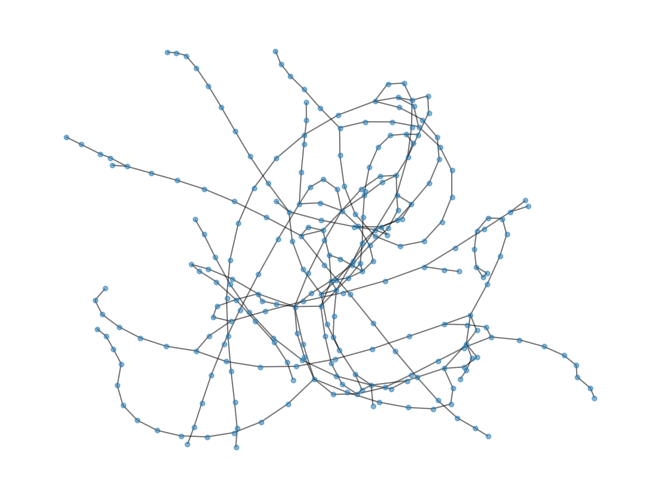

In [32]:
# plot network a-spatially (not using geolocations)
nx.draw(g, node_size=10, alpha=.5)

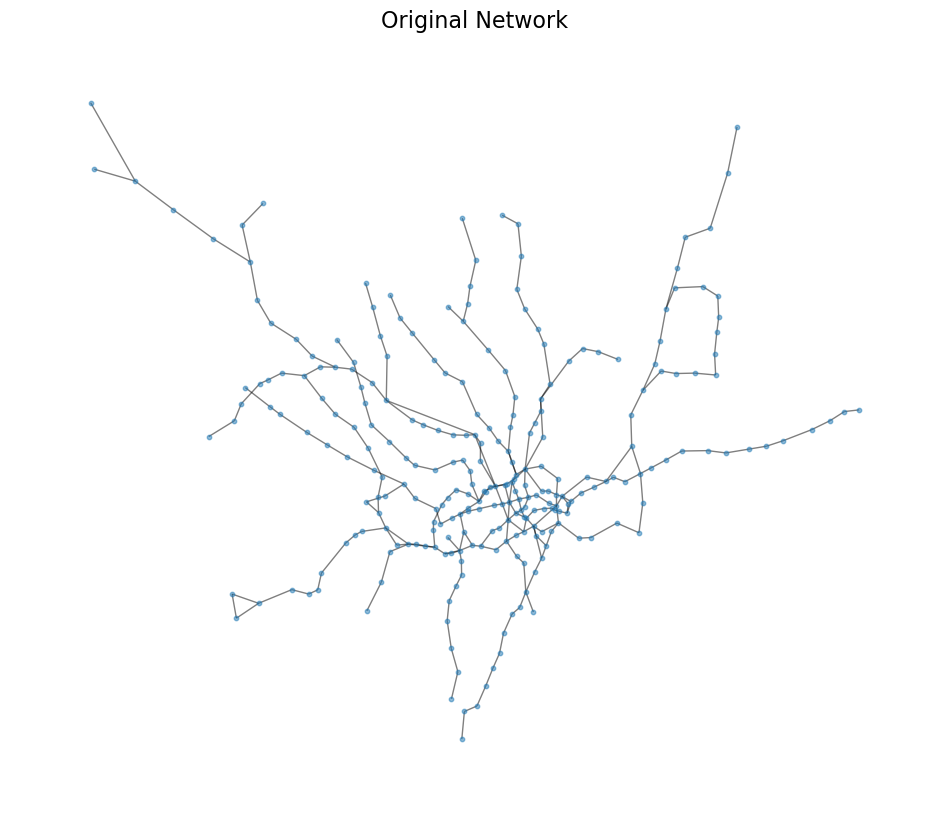

In [33]:
# using the coordinate data to plot the node positions spatially 
# as per: https://transport-systems.imperial.ac.uk/tf/60008_21/n2_3_studying_the_london_underground.html
coords = list(zip(u_stations['longitude'],u_stations['latitude']))
pos = dict(zip(u_stations['id'], coords))

# creating the frame and canvas size of the plot
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title("Original Network", fontsize=16)
nx.draw(g,pos,node_size=10, alpha=.5)

# saving graph plot at a jpg
plt.savefig("output/Original_network.jpg", dpi=300, bbox_inches='tight')

In [34]:
# degre_histogram() function returns a list of the frequency of each degree value.
nx.degree_histogram(g)

[0, 19, 195, 21, 21, 4, 4, 2]

#### Simple interactive plot of underground network using bokeh - used for data exploration

In [35]:
# uncomment the following line to install bokeh
#!pip install bokeh

In [36]:
# importing the relevant libraries 
from bokeh.plotting import figure, show, from_networkx
from bokeh.models import Circle, MultiLine, StaticLayoutProvider

In [37]:
# as per: https://melaniewalsh.github.io/Intro-Cultural-Analytics/06-Network-Analysis/02-Making-Network-Viz-with-Bokeh.html

# choose a title
title = 'London Underground Network'

# setting which categories that will appear when hovering over each node
HOVER_TOOLTIPS = [("Station", "@name")]

# create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
             x_range = (-.7,.4), y_range = (51.1,51.8), title=title)

# create a network graph object with spring layout
network_graph = from_networkx(g, nx.spring_layout, scale=10, center=(0, 0))

# set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')
# set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

# setting custome node position as per: https://nbviewer.org/github/komo-fr/networkx2bokeh_note/blob/master/notebooks/networkx2bokeh_layout_for_custom_position.ipynb
fixed_layout_provider = StaticLayoutProvider(graph_layout=pos)
network_graph.layout_provider = fixed_layout_provider

# add network graph to the plot
plot.renderers.append(network_graph)

show(plot)


# 2. Calculate the two necessary centrality measures


- **Important/prominent nodes** are those that are **extensively linked** or involved with other nodes. Generally, high centrality values indicates high importance.
- A **central node** is one with **many links**

##### Degree - "the number of edges that are connected to a node"

## Node centrality - this analysis will look at two types

#### 1. Degree Centrality:
- The number of links incident upon a node (i.e., the number of ties that a node has).
- Calculated by dividing node degree by the total number of nodes -1.

#### 2. Betweenness Centrality:
- Measure of a node falling in the shortest paths of other pairs of nodes.
- Value is the sum of the fraction of all-pairs shortest paths that pass through it, as per:
https://www.youtube.com/watch?v=HnnMAn-2Q6c 

- For example, a node with a degree of 1 (node representing a dead end in the network) will have a betweenness centrality value of 0. To get from any node to any other node using the shortest path, you will not go through a route with a dead end.
- As a result, linked nodes (nodes with a high degree) will have a higher centrality score.

- Betweenness centrality popular metric of centrality based on shortest paths between nodes.


Please note, there are many different types of centrality measures using Networkx 
https://networkx.org/documentation/stable/reference/algorithms/centrality.html 

### Calculating the two centrality measures

In [38]:
# copying the orignal graph using the networkx copy() function and saving in the varaible 'g_cen'
g_cen = g.copy()

In [39]:
# setting node attributes for betweenness_centrality and degree_centrality
# setting the weight for betweenness_centrality as 'total_ec' (total entry count) of passengers
nx.set_node_attributes(g_cen, nx.algorithms.centrality.betweenness_centrality(g_cen, weight='total_ec'), "betw_centrality")
nx.set_node_attributes(g_cen, nx.algorithms.centrality.degree_centrality(g_cen), "degree_centrality")

In [40]:
# build lists of networkx node attributes to display the inforamtion in a dataframe 

# creating and populating lists with the netowrkx node data
degrees = [val for (node, val) in g_cen.degree()]
names = [g_cen.nodes[node]['name'] for node in g_cen]
bcentral = [round(g_cen.nodes[node]["betw_centrality"],5) for node in g_cen]
degree_centrality = [round(g_cen.nodes[node]['degree_centrality'],5) for node in g_cen]

# assemble lists into a data frame
stats_df = pd.DataFrame({'name':names, 'degree': degrees, 'betw_centrality':bcentral, 'degree_centrality':degree_centrality})

In [41]:
# displaying the stats dataframe
stats_df
# in this data set, nodes with a degree of 2 have a degree centrality value of 0.00755 becuase: 2/(266-1) = 0.00755

,name,degree,betw_centrality,degree_centrality
0,Baker Street,7,0.34222,0.02642
1,Marylebone,2,0.00537,0.00755
2,Edgware Road (B),2,0.00206,0.00755
3,Regent's Park,2,0.02293,0.00755
4,Oxford Circus,6,0.14634,0.02264
...,...,...,...,...
261,Hounslow Central,2,0.02985,0.00755
262,Blackhorse Road,2,0.00755,0.00755
263,Tottenham Hale,2,0.01504,0.00755
264,Walthamstow Central,1,0.00000,0.00377


# 3. Plot the network again, but now change the colour of the stations based on centrality (one plot per measure)

In [42]:
# importing additional library
import matplotlib.patches as mpatches

In [43]:
# creating a function to plot networkx graphs with coloured nodes - adopted from Lecture 7 - Network Analysis

def plot_graph_color_nodes(graph, colour_attr, plot_title):
    """ Plot graph changing the node colours based on @colour_attr """
    # defining the plot frame and canvas 
    fig, ax = plt.subplots(figsize=(12, 10))
    # adding a title 
    ax.set_title(plot_title, fontsize=16)
    # generate sequence of colors based on attribute
    # note: g.nodes[node][colour_attr] access attribute <colour_attr> in node with id <node>
    attribute = [graph.nodes[node][colour_attr] for node in graph]
    colors = [i/max(attribute) for i in attribute]
    # using the coordiante data to plot the node positions spatially 
    coords = list(zip(u_stations['longitude'],u_stations['latitude']))
    pos = dict(zip(u_stations['id'], coords))
    
    # create and plot legend
    legend_tiles = [mpatches.Patch(color="#800026", label="High Value"),
                    mpatches.Patch(color="#e31a1c", label=""),
                    mpatches.Patch(color="#fd8d3c", label=""),
                    mpatches.Patch(color="#fed976", label=""),
                    mpatches.Patch(color="#ffffcc", label="Low Value"),
               ]
    plt.legend(handles=legend_tiles, loc="lower left")
    # draw graph with colour sequence
    nx.draw(graph, pos, node_size=10, node_color=colors, cmap=plt.cm.YlOrRd, edge_color='gray')

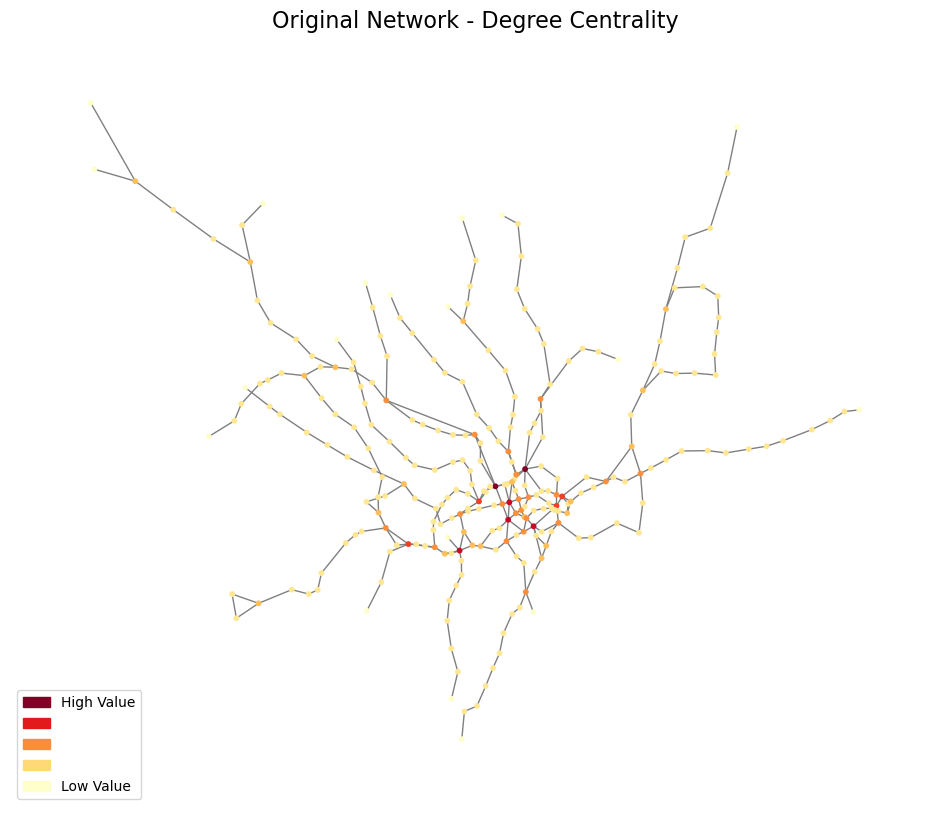

In [44]:
# plotting and exporting Degree Centrality plot
plot_graph_color_nodes(g_cen, 'degree_centrality', 'Original Network - Degree Centrality')
plt.savefig("output/Original_network_DC.jpg", dpi=300, bbox_inches='tight')

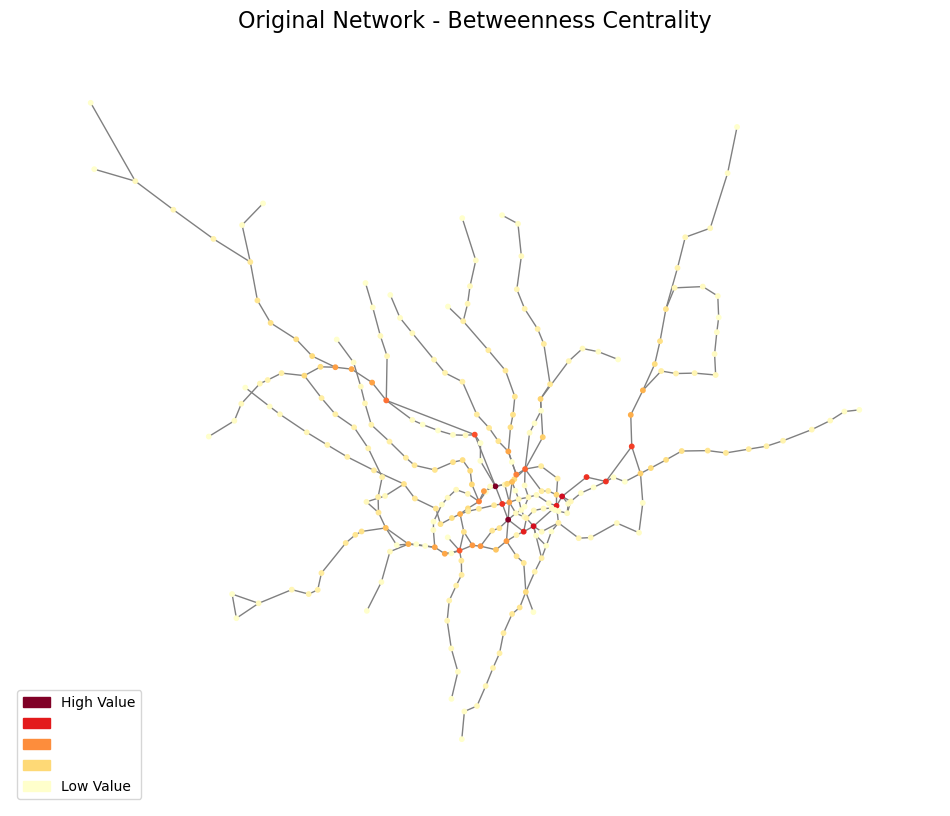

In [45]:
# plotting and exporting Betweenness Centrality plot
plot_graph_color_nodes(g_cen, 'betw_centrality', 'Original Network - Betweenness Centrality')
plt.savefig("output/Original_network_BC.jpg", dpi=300, bbox_inches='tight')

# 4. Perform the following attacks on the network
    
### a) Close N random stations:


In [46]:
# removing random nodes from a network as per https://stackoverflow.com/questions/34909588/how-to-remove-random-number-of-nodes-from-a-network-graph

# importing the random library
import random

# storing all nodes of the original network grapgh 'g_cen' as a list in the variable 'list_of_nodes'
list_of_nodes = list(g_cen.nodes())

In [47]:
# storing the integer 3 in the vairable 'sample' - we want to remove 3 stations 
sample = 3

# we will use random nodes already stored in the variable 'RandomSample' to ensure the analysis write up is consistent with the script
RandomSample = [26, 100, 132]

# uncomment the following line to generate a new RandomSample 
#RandomSample = random.sample(list_of_nodes, sample)

In [48]:
RandomSample 

[26, 100, 132]

In [49]:
# checking which random staions are to be removed from the network

#u_connections_ec[u_connections_ec["station1"] == 26]
#u_connections_ec[u_connections_ec["station1"] == 100]
#u_connections_ec[u_connections_ec["station2"] == 132]

In [50]:
# copying the orignal graph using the networkx copy() function and saving in the variable 'g_rand'
g_rand = g_cen.copy()

In [51]:
len(list(g_rand.nodes()))
# 'g_rand' has 266 nodes, remember it's just a copy of the graph 'g'

266

In [52]:
# remvoving nodes stored in 'RandomSample' from the graph 'g_rand'
g_rand.remove_nodes_from(RandomSample)

In [53]:
# len of g_rand graph 
len(list(g_rand.nodes()))
# 'g_rand' now has 263 nodes

263

In [54]:
# creating a graph of removed stations for plotting 

# copying the original graph with no stations removed 
g_rand_removed = g_cen.copy()

# creating a list of stations that weren't remvoved from the random attack
remaining_stations = list(g_rand.nodes())

# removing all the remaining stations from the graph, leaving only the stations that were originally removed due to the random attack
g_rand_removed.remove_nodes_from(remaining_stations)

len(list(g_rand_removed.nodes()))
# 'g_rand_removed' contains the three nodes that were attacked

3

### b) Close N specific stations based on some criteria, e.g., spatial location or number of passengers

In [55]:
# sorting the u_connections_ec by 'betw_centrality' values 
u_connections_ec.sort_values(by='Total', ascending=False)

# Waterloo, King's Cross St. Pancras, Liverpool Street have the three highest total passenger counts
# interestinly Blackfiars has a passenger count of 0. Perhaps the station was closed on the day the passenger data was collected.
# we will leave it as 0 for the purpose of this analysis 

,station1,station2,latitude_x,longitude_x,station1_name,station2_name,Total
46,279,285,51.5036,-0.1143,Waterloo,Westminster,130627.0
125,145,223,51.5308,-0.1238,King's Cross St. Pancras,Russell Square,108944.0
87,156,167,51.5178,-0.0823,Liverpool Street,Moorgate,103345.0
86,156,167,51.5178,-0.0823,Liverpool Street,Moorgate,103345.0
85,156,167,51.5178,-0.0823,Liverpool Street,Moorgate,103345.0
...,...,...,...,...,...,...,...
102,215,301,51.6171,0.0439,Roding Valley,Woodford,424.0
154,25,161,51.5120,-0.1031,Blackfriars,Mansion House,0.0
40,25,255,51.5120,-0.1031,Blackfriars,Temple,0.0
39,25,255,51.5120,-0.1031,Blackfriars,Temple,0.0


In [56]:
# filtering the u_connections_ec dataframe to identify stations ids

# King's Cross St. Pancras
u_connections_ec.loc[u_connections_ec["station1_name"] == "King's Cross St. Pancras"]
# station1 node id = 145

# Waterloo
u_connections_ec.loc[u_connections_ec["station1_name"] == "Waterloo"]
# station1 node id = 279

# Liverpool Street
u_connections_ec.loc[u_connections_ec["station1_name"] == "Liverpool Street"]
# station1 node id = 156

,station1,station2,latitude_x,longitude_x,station1_name,station2_name,Total
85,156,167,51.5178,-0.0823,Liverpool Street,Moorgate,103345.0
86,156,167,51.5178,-0.0823,Liverpool Street,Moorgate,103345.0
87,156,167,51.5178,-0.0823,Liverpool Street,Moorgate,103345.0


In [57]:
# copying the original graph using the networkx copy() function and saving in the varaible 'g_spec'
g_spec = g_cen.copy()


In [58]:
# King's Cross St. Pancras, Waterloo and Liverpool Street has a node id of '11, 107, 145'
# removing them from the graph using the remove_nodes_from() function
g_spec.remove_nodes_from([145, 279, 156])

In [59]:
len(list(g_spec.nodes()))
# g_spec now has 266 nodes rather than 263

263

In [60]:
# creating a graph of only the removed stations for plotting 

# copying the original graph with no stations removed 
g_spec_removed = g_cen.copy()

# creating a list of stations that weren't remvoved from the targeted attack
remaining_stations_spec = list(g_spec.nodes())

# removing all the remaining stations from the graph, leaving only the stations that were originally removed due to the targeted attack
g_spec_removed.remove_nodes_from(remaining_stations_spec)

len(list(g_spec_removed.nodes()))
# 'g_spec_removed' contains the three nodes that were attacked

3

# 5. After each attack, repeat points 2 and 3.

### a) Random Attack

In [61]:
# recalculating attributes following a random attack 

# g_rand graph - setting node attributes for betweenness_centrality and degree_centrality
# setting the weight for betweenness_centrality as 'total ec' passenger count
nx.set_node_attributes(g_rand, nx.algorithms.centrality.betweenness_centrality(g_rand, weight='total ec'), "betw_centrality")
nx.set_node_attributes(g_rand, nx.algorithms.centrality.degree_centrality(g_rand), "degree_centrality")

In [62]:
# build lists for data frame
degrees = [val for (node, val) in g_rand.degree()]
# this is a way to get the values of an attribute in a graph (in this case 'name')
names = [g_rand.nodes[node]['name'] for node in g_rand]
bcentral = [round(g_rand.nodes[node]["betw_centrality"],5) for node in g_rand]
degree_centrality = [round(g_rand.nodes[node]['degree_centrality'],5) for node in g_rand]

# assemble lists into a data frame
stats_df_rand = pd.DataFrame({'name':names, 'degree': degrees, 'betw_centrality':bcentral, 'degree_centrality':degree_centrality})

In [63]:
# adjusting the plotting function to also plot the station that have been remvoed from the network

def plot_graph_color_nodes_remov(graph, colour_attr, plot_title, removed_nodes_graph):
    """ Plot graph changing the node colours based on @colour_attr and includes removed stations"""
    # defining the plot frame and canvas 
    fig, ax = plt.subplots(figsize=(12, 10))
    # adding a title 
    ax.set_title(plot_title, fontsize=16)
    # generate sequence of colors based on attribute
    # note: g.nodes[node][colour_attr] access attribute <colour_attr> in node with id <node>
    attribute = [graph.nodes[node][colour_attr] for node in graph]
    colors = [i/max(attribute) for i in attribute]
    # using the coordiante data to plot the node positons spatially 
    coords = list(zip(u_stations['longitude'],u_stations['latitude']))
    pos = dict(zip(u_stations['id'], coords))
    
    # create and plot legend
    legend_tiles = [mpatches.Patch(color="#800026", label="High Value"),
                    mpatches.Patch(color="#e31a1c", label=""),
                    mpatches.Patch(color="#fd8d3c", label=""),
                    mpatches.Patch(color="#fed976", label=""),
                    mpatches.Patch(color="#ffffcc", label="Low Value"),
                    mpatches.Patch(color="#000000", label="Removed"),
               ]
    plt.legend(handles=legend_tiles, loc="lower left")
    # draw graph with colour sequence
    nx.draw(graph, pos, node_size=10, node_color=colors, cmap=plt.cm.YlOrRd, edge_color='gray')
    # draw additional graph that displays the removed nodes in black 
    nx.draw(removed_nodes_graph, pos, node_size=10, node_color='black')

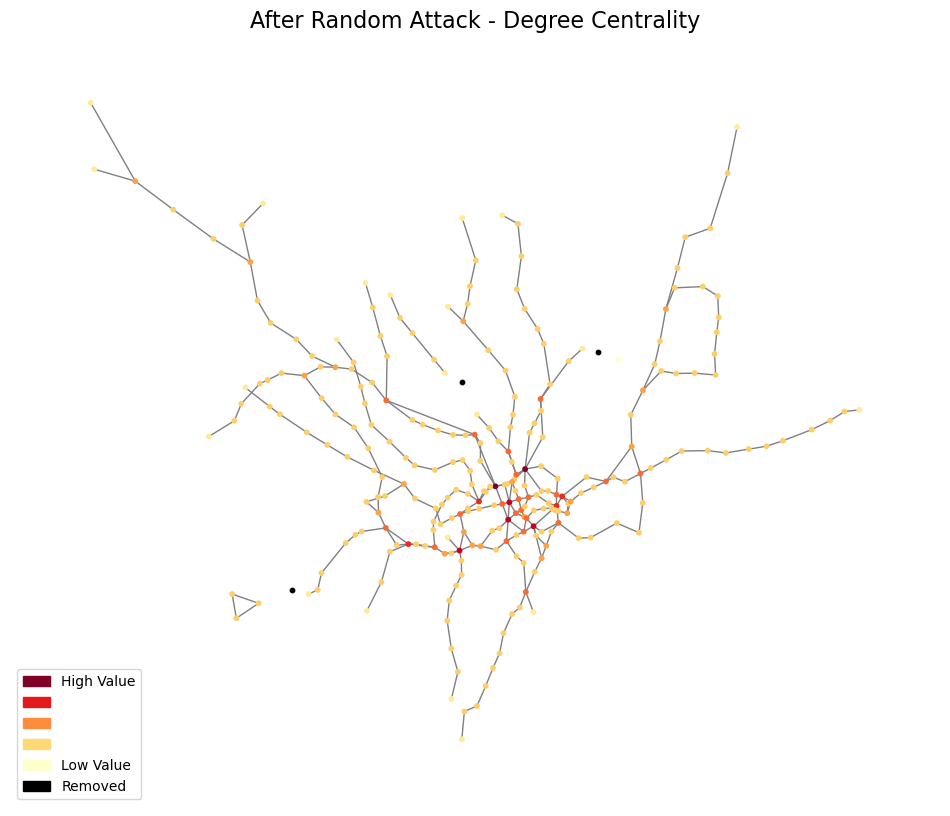

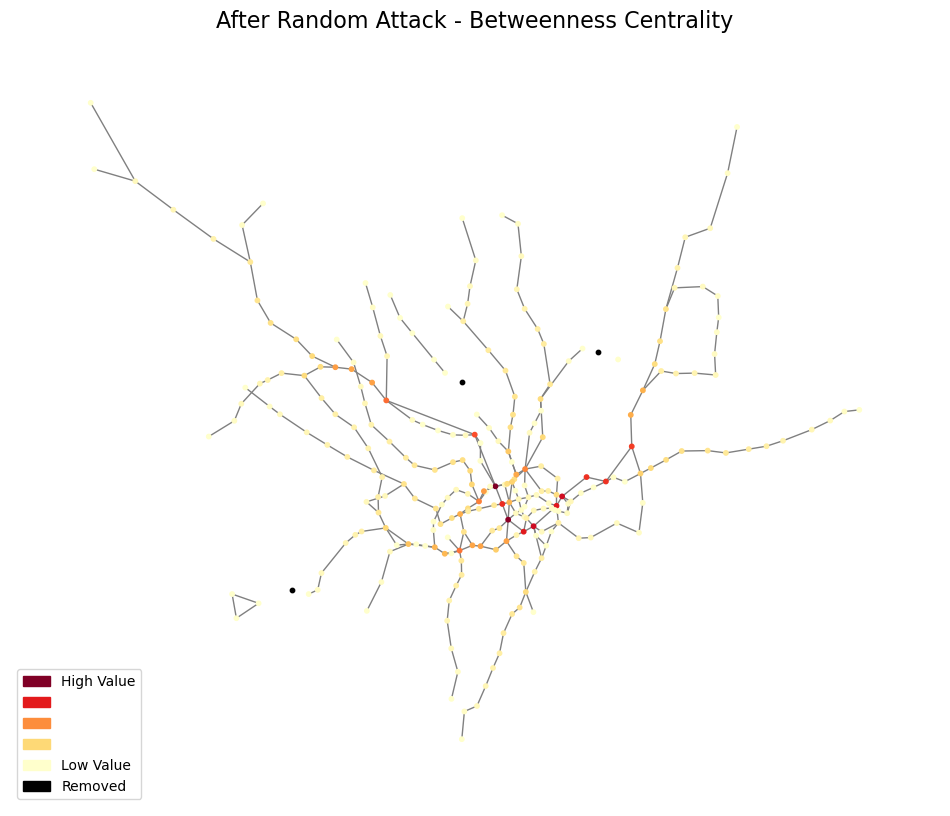

In [64]:
# plotting and exporting graphs 
plot_graph_color_nodes_remov(g_rand, 'degree_centrality', 'After Random Attack - Degree Centrality', g_rand_removed)
plt.savefig("output/Random_DC.jpg", dpi=300, bbox_inches='tight')
plot_graph_color_nodes_remov(g_rand, 'betw_centrality', 'After Random Attack - Betweenness Centrality', g_rand_removed)
plt.savefig("output/Random_BC.jpg", dpi=300, bbox_inches='tight')

### b) Targated attack 

In [65]:
# g_spec graph - setting node attributes for betweenness_centrality and degree_centrality
# setting the weight for betweenness_centrality as 'total_ec' (total entry count) of passengers
nx.set_node_attributes(g_spec, nx.algorithms.centrality.betweenness_centrality(g_spec, weight='total_ec'), "betw_centrality")
nx.set_node_attributes(g_spec, nx.algorithms.centrality.degree_centrality(g_spec), "degree_centrality")

# build lists for data frame
degrees = [val for (node, val) in g_spec.degree()]
# this is a way to get the values of an attribute in a graph (in this case 'name')
names = [g_spec.nodes[node]['name'] for node in g_spec]
bcentral = [round(g_spec.nodes[node]["betw_centrality"],5) for node in g_spec]
degree_centrality = [round(g_spec.nodes[node]['degree_centrality'],5) for node in g_spec]

# assemble lists into a data frame
stats_df_spec = pd.DataFrame({'name':names, 'degree': degrees, 'betw_centrality':bcentral, 'degree_centrality':degree_centrality})

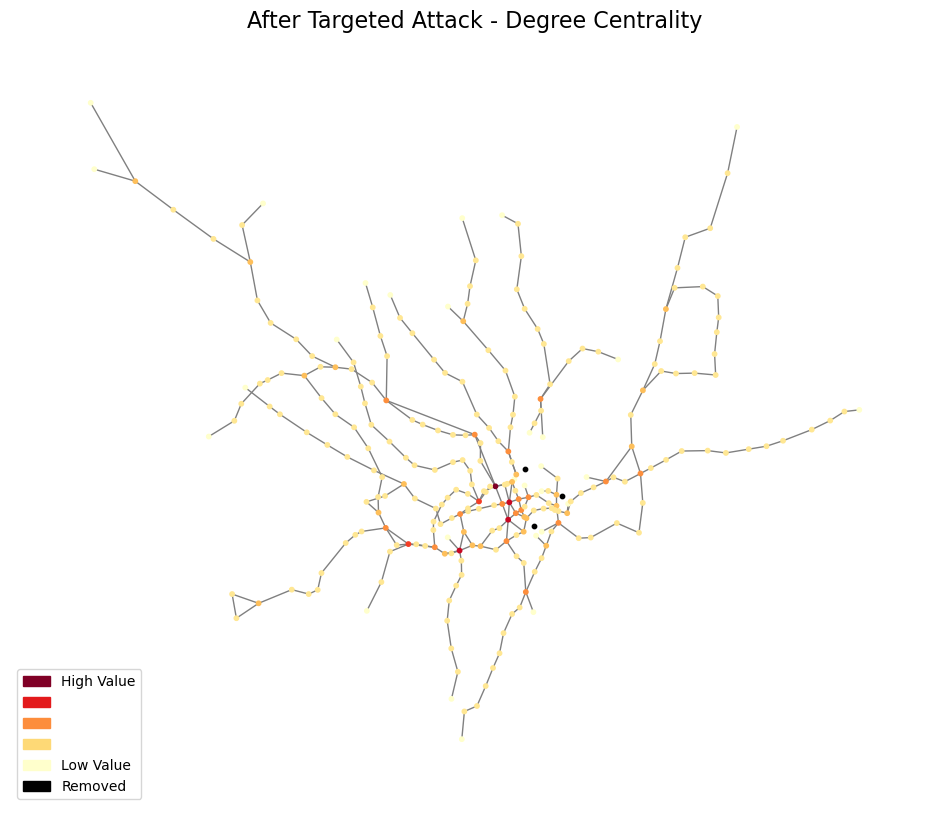

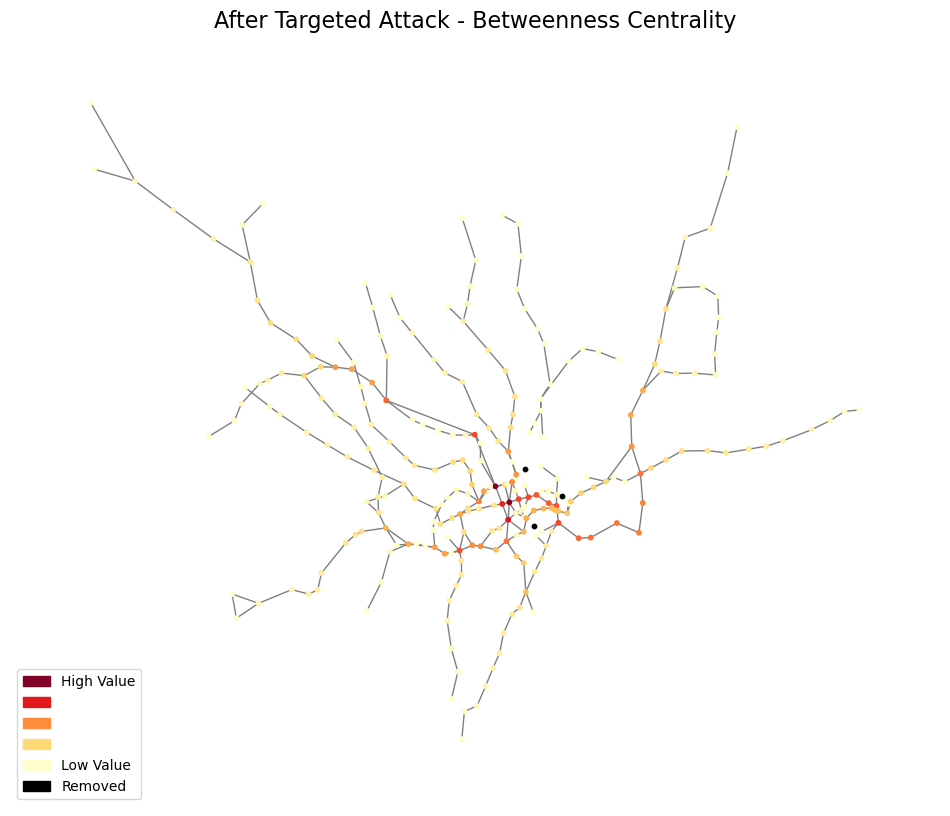

In [66]:
# plotting and exporting graphs 
plot_graph_color_nodes_remov(g_spec, 'degree_centrality', 'After Targeted Attack - Degree Centrality', g_spec_removed)
plt.savefig("output/Targeted_DC.jpg", dpi=300, bbox_inches='tight')
plot_graph_color_nodes_remov(g_spec, 'betw_centrality', 'After Targeted Attack - Betweenness Centrality', g_spec_removed)
plt.savefig("output/Targeted_BC.jpg", dpi=300, bbox_inches='tight')

## Further data exploration

In [67]:
# exploring the statistics dataframes before and after the attacks
stats_df
stats_df_rand
stats_df_spec

,name,degree,betw_centrality,degree_centrality
0,Baker Street,7,0.29993,0.02672
1,Marylebone,2,0.00491,0.00763
2,Edgware Road (B),2,0.00211,0.00763
3,Regent's Park,2,0.07308,0.00763
4,Oxford Circus,6,0.29727,0.02290
...,...,...,...,...
258,Hounslow Central,2,0.02819,0.00763
259,Blackhorse Road,2,0.00044,0.00763
260,Tottenham Hale,2,0.00082,0.00763
261,Walthamstow Central,1,0.00000,0.00382


In [68]:
# sorting the original network by degree centrality value 
network_DC_table = stats_df.sort_values(by='degree_centrality', ascending=False).head(10)
stats_df.sort_values(by='degree_centrality', ascending=False).head(10)

,name,degree,betw_centrality,degree_centrality
0,Baker Street,7,0.34222,0.02642
92,King's Cross St. Pancras,7,0.20009,0.02642
4,Oxford Circus,6,0.14634,0.02264
22,Waterloo,6,0.27436,0.02264
115,Earl's Court,6,0.20716,0.02264
14,Green Park,6,0.33773,0.02264
23,Bank,5,0.25450,0.01887
137,Turnham Green,5,0.12984,0.01887
48,Liverpool Street,5,0.27736,0.01887
17,Paddington,5,0.18005,0.01887


In [69]:
# uncomment the following line to install 'dataframe_image'
#!pip install dataframe_image

In [70]:
import dataframe_image as dfi

In [71]:
dfi.export(network_DC_table, "output/network_DC_table.png")

In [72]:
# sorting the original network by betweenness centrality value 
network_BC_table = stats_df.sort_values(by='betw_centrality', ascending=False).head(10)
dfi.export(network_BC_table, "output/network_BC_table.png")
stats_df.sort_values(by='betw_centrality', ascending=False).head(10)

,name,degree,betw_centrality,degree_centrality
0,Baker Street,7,0.34222,0.02642
14,Green Park,6,0.33773,0.02264
48,Liverpool Street,5,0.27736,0.01887
22,Waterloo,6,0.27436,0.02264
23,Bank,5,0.25450,0.01887
27,Westminster,4,0.25367,0.01509
49,Bethnal Green,2,0.23785,0.00755
63,Mile End,4,0.23748,0.01509
8,Bond Street,4,0.23554,0.01509
99,Stratford,3,0.22668,0.01132


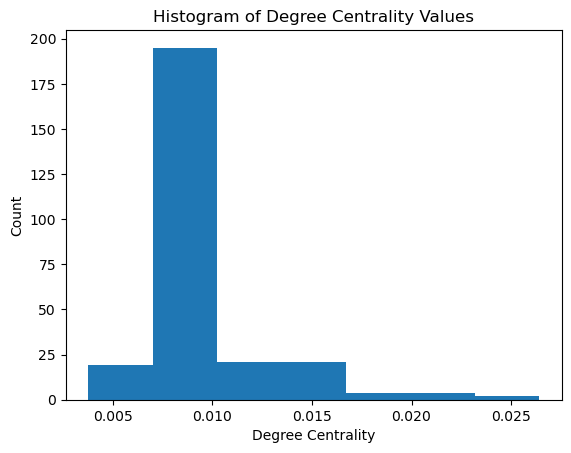

In [73]:
# creating a histogram of degree centrality  
stats_df.hist(column='degree_centrality', bins=7, grid=False)
plt.title("Histogram of Degree Centrality Values")
plt.xlabel("Degree Centrality")
plt.ylabel("Count")

plt.savefig("output/Hist_DC.jpg", dpi=300, bbox_inches='tight')

In [74]:
stats_df["degree"].describe()

count    266.000000
mean       2.308271
std        0.968800
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        7.000000
Name: degree, dtype: float64

In [75]:
stats_df.degree_centrality.value_counts()

0.00755    195
0.01509     21
0.01132     21
0.00377     19
0.02264      4
0.01887      4
0.02642      2
Name: degree_centrality, dtype: int64

### Random attack analysis

In [76]:
# displaying stats with following random attack
rand_network_DC_table = stats_df_rand.sort_values(by='degree_centrality', ascending=False).head(10)

dfi.export(rand_network_DC_table, "output/rand_network_DC_table.png")

rand_network_DC_table

,name,degree,betw_centrality,degree_centrality
0,Baker Street,7,0.33104,0.02672
92,King's Cross St. Pancras,7,0.17029,0.02672
22,Waterloo,6,0.27197,0.02290
4,Oxford Circus,6,0.11956,0.02290
115,Earl's Court,6,0.18211,0.02290
14,Green Park,6,0.32177,0.02290
48,Liverpool Street,5,0.26789,0.01908
17,Paddington,5,0.17363,0.01908
23,Bank,5,0.25203,0.01908
137,Turnham Green,5,0.10482,0.01908


In [77]:
# displaying stats with following random attack
rand_network_BC_table = stats_df_rand.sort_values(by='betw_centrality', ascending=False).head(10)

dfi.export(rand_network_BC_table, "output/rand_network_BC_table.png")

rand_network_BC_table

,name,degree,betw_centrality,degree_centrality
0,Baker Street,7,0.33104,0.02672
14,Green Park,6,0.32177,0.02290
22,Waterloo,6,0.27197,0.02290
48,Liverpool Street,5,0.26789,0.01908
23,Bank,5,0.25203,0.01908
27,Westminster,4,0.25010,0.01527
8,Bond Street,4,0.23395,0.01527
49,Bethnal Green,2,0.22991,0.00763
63,Mile End,4,0.22987,0.01527
99,Stratford,3,0.22006,0.01145


### Targeted attack analysis

In [78]:
# displaying stats with following targeted attack
tar_network_DC_table = stats_df_spec.sort_values(by='degree_centrality', ascending=False).head(10)

dfi.export(tar_network_DC_table, "output/tar_network_DC_table.png")

tar_network_DC_table

,name,degree,betw_centrality,degree_centrality
0,Baker Street,7,0.29993,0.02672
14,Green Park,6,0.23046,0.02290
112,Earl's Court,6,0.19188,0.02290
4,Oxford Circus,6,0.29727,0.02290
134,Turnham Green,5,0.12187,0.01908
17,Paddington,5,0.15618,0.01908
61,Mile End,4,0.07761,0.01527
172,Wembley Park,4,0.17604,0.01527
220,Stockwell,4,0.10056,0.01527
210,Camden Town,4,0.13451,0.01527


In [79]:
tar_network_BC_table = stats_df_spec.sort_values(by='betw_centrality', ascending=False).head(10)

dfi.export(tar_network_BC_table, "output/tar_network_BC_table.png")

tar_network_BC_table

,name,degree,betw_centrality,degree_centrality
0,Baker Street,7,0.29993,0.02672
4,Oxford Circus,6,0.29727,0.02290
14,Green Park,6,0.23046,0.02290
8,Bond Street,4,0.21693,0.01527
41,Tottenham Court Road,4,0.19631,0.01527
10,Finchley Road,4,0.19554,0.01527
42,Holborn,4,0.19403,0.01527
52,London Bridge,4,0.19245,0.01527
112,Earl's Court,6,0.19188,0.02290
22,Bank,3,0.18735,0.01145


array([[<AxesSubplot: title={'center': 'betw_centrality'}>]], dtype=object)

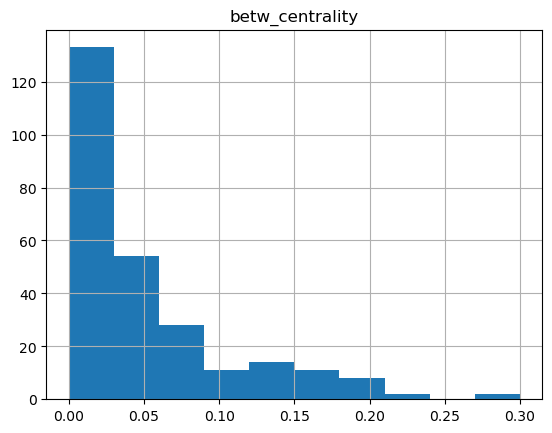

In [80]:
stats_df_spec.hist(column='betw_centrality')

#### Seaborn comparison histogram

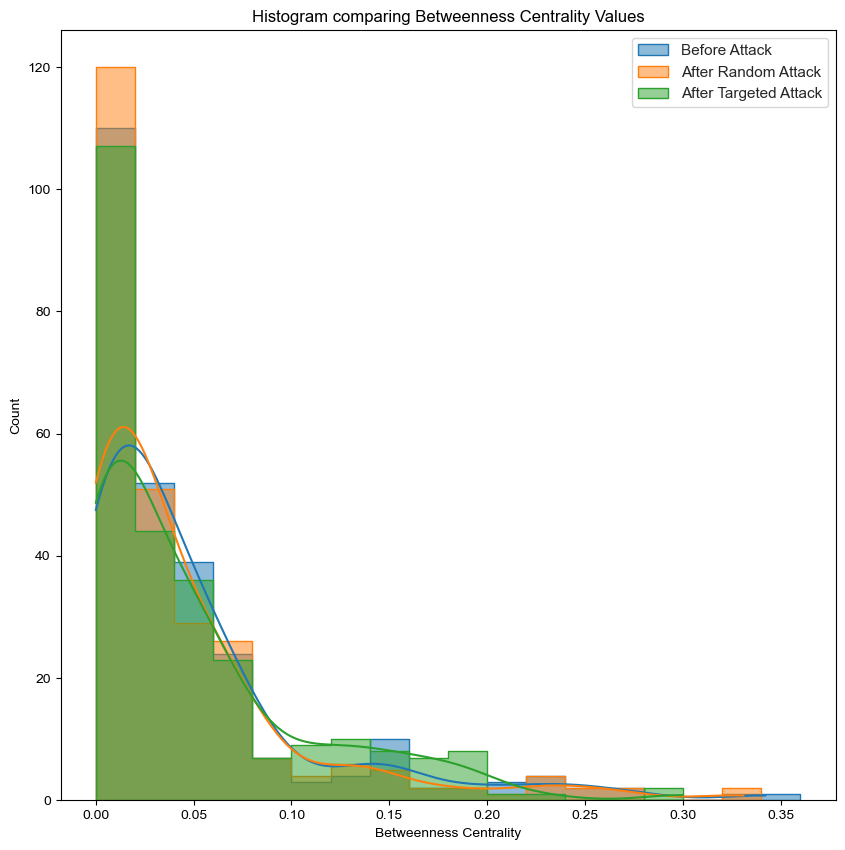

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.set(style="white")

sns.histplot(data=stats_df, x="betw_centrality", label="Before Attack", kde=True, element="step", binwidth=0.02)
sns.histplot(data=stats_df_rand, x="betw_centrality", label="After Random Attack", kde=True, element="step", binwidth=0.02)
sns.histplot(data=stats_df_spec, x="betw_centrality", label="After Targeted Attack", kde=True, element="step", binwidth=0.02)

ax.set(xlabel='Betweenness Centrality', ylabel='Count', title='Histogram comparing Betweenness Centrality Values')
plt.legend() 
plt.savefig("output/Hist_compare_BC.jpg", dpi=300, bbox_inches='tight')

In [82]:
# creating a new dataframe with betweenness centrality before, after random and after targeted attacks
df_bc = pd.DataFrame().assign(Before=stats_df["betw_centrality"], Random=stats_df_rand["betw_centrality"], Targeted=stats_df_spec["betw_centrality"])
df_bc

,Before,Random,Targeted
0,0.34222,0.33104,0.29993
1,0.00537,0.00526,0.00491
2,0.00206,0.00199,0.00211
3,0.02293,0.01971,0.07308
4,0.14634,0.11956,0.29727
...,...,...,...
261,0.02985,0.00000,0.00000
262,0.00755,0.05176,0.08637
263,0.01504,NaN,NaN
264,0.00000,NaN,NaN


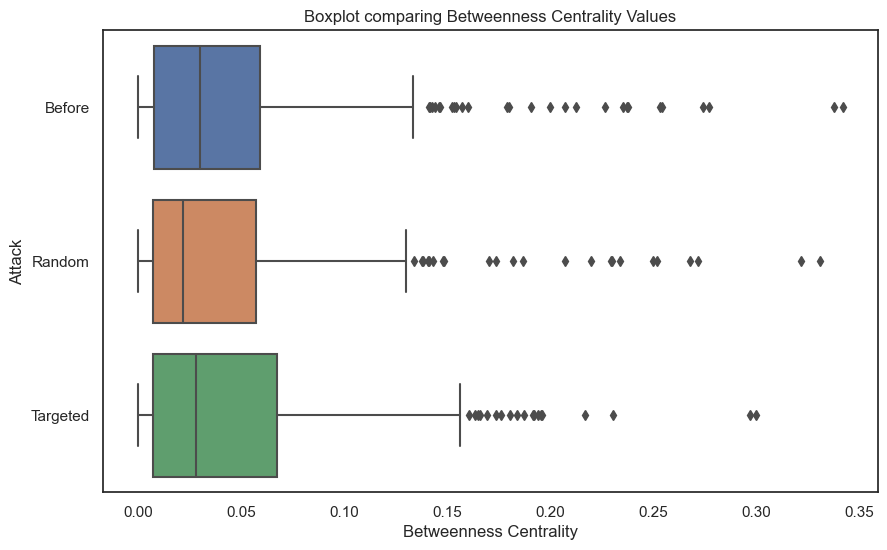

In [83]:
# creating a betweenness centrality comparison boxplot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set(xlabel='Betweenness Centrality', ylabel='Attack', title='Boxplot comparing Betweenness Centrality Values')
sns.boxplot(data=df_bc, orient="h")

plt.savefig("output/Boxp_compare_BC.jpg", dpi=300, bbox_inches='tight')

In [84]:
# exploring be betweenness centrality across the different attack scenarios 

In [85]:
df_bc["Before"].describe()
df_bc["Random"].describe()
df_bc["Targeted"].describe()

count    263.000000
mean       0.049326
std        0.057588
min        0.000000
25%        0.007140
50%        0.028190
75%        0.067190
max        0.299930
Name: Targeted, dtype: float64